In [1]:
# Functions from part1 are in util.py
# Functions from part2 are in util2.py

# util.py functions:
#
# parse_data(filename) , parse_data_truth(filename)
# shingle_document(string,k)
# jaccard(string1,string2)
# processData(fileID,k)
#
# util2.py functions:
#
# processShingles(filename,k), invert_shingles(shingled_documents)
# make_hashes(numHashes)
# make_minhash_signature(shingled_data numHashes)
# minhash_similarity(id1,id2,minhash_matrix, docids)
# processJsimMH(filename,k,numHashes):

from util import *
from util2 import *
import scipy.optimize as opt
import matplotlib.pyplot as plt
import math
import time

### Hash Functions

In [2]:
# Given functions
def _make_vector_hash(num_hashes, m=4294967295):
    hash_fns = make_hashes(num_hashes)
    def _f(vec):
        acc = 0
        for i in range(len(vec)):
            h = hash_fns[i]
            acc += h(vec[i])
        return acc % m
    return _f

def _choose_nbands(threshold, nhashes):
    error_fun = lambda x: (threshold-((1/x[0])**(x[0]/nhashes)))**2
    res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(res['x'][0]))
    r = int(nhashes / b)
    final_t = (1/b)**(1/r)
    return b, final_t

### LSH Function

In [3]:
from collections import defaultdict

def do_lsh(minhash, numhashes, docids, threshold):
    b, _ = _choose_nbands(threshold, numhashes)
    r = int(numhashes / b)
    narticles = len(docids)
    hash_func = _make_vector_hash(r)
    buckets = []
    for band in range(b):
        start_index = int(band * r)
        end_index = min(start_index + r, numhashes) - 1 # w/o -1 you get an off by 1 index error
        cur_buckets = defaultdict(list)
        for j in range(narticles):
        # THIS IS WHAT YOU NEED TO IMPLEMENT
            cur_buckets[docids[j]] = hash_func(minhash[start_index:end_index,j])
        buckets.append(cur_buckets)
    
    # hash tables per a band
    return buckets


### Calculate the single MinHash signature matrix

In [4]:
# Load data and calculate minHash matrix for given hashes and shingle size
fname = 'data/articles_10000.'
dat_t = parse_data_truth(fname+'truth')

k_size = 10
numHashes = 1000

if 0:
    start_time = time.time()
    # get a list of tuples of the form (docid, [shingles])
    shingles = processShingles(fname+'train',k_size)
    print 'SHINGLING | --- '+str(time.time()-start_time)+' seconds --- |'  
    # create minhash signature from data
    mh_matrix, docids = make_minhash_signature(shingles,numHashes)
    print 'MINHASH | --- '+str(time.time()-start_time)+' seconds --- |'
    np.save('data_gen/data_100_lsh.npy', mh_matrix)
else:
    mh_matrix = np.load('data_gen/data_10000_lsh.npy')
    docids = np.load('data_gen/data_10000_lsh_docid.npy')

### Find candidate pairs

In [5]:
def processLSH(bands):
    candidate_pairs = []
    
    # iterate over each band
    for band in bands:
        inverse_band = defaultdict(list)
        # generate dictionary with vector hashes as keys and docids as values
        for k, v in band.iteritems():
            inverse_band[v].append(k)
        # iterate through and find documents that hashed to same value
        for k,v in inverse_band.iteritems():
            if len(v) > 1:
                candidate_pairs.append((v[0],v[1]))
    return candidate_pairs                

In [31]:
def calcConfusionMatrix(thresholds):
    TP_counts = []
    FP_counts = []
    FN_counts = []
    for threshold in thresholds:
        buckets = do_lsh(mh_matrix, numHashes, docids, threshold)
        dat_t_pred = list(set(processLSH(buckets)))
        # iterate through truth table
        TP_count = 0
        for truth_pair in dat_t:
            for truth_pair_pred in dat_t_pred:
                if truth_pair == truth_pair_pred or truth_pair == truth_pair_pred[::-1]:
                    TP_count+=1
                    break
        TP_counts.append(TP_count)
        FP_counts.append(len(dat_t_pred)-TP_count)
        FN_counts.append(len(dat_t)-TP_count)
    return TP_counts,FP_counts,FN_counts

### Calculate Conufsion Matrix and plot results

In [56]:
# Calc sensitivity
sensitivity = []
thresholds1 = np.linspace(0.9,0.999,10)
TPs,FPs,FNs = calcConfusionMatrix(thresholds1)
for (TP,FP,FN) in zip(TPs,FPs,FNs):
    sensitivity.append(1.0*TP/(TP+FN))

print sensitivity
print TPs
print FPs
print FNs

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9875, 0.9625, 0.775, 0.625]
[80, 80, 80, 80, 80, 80, 79, 77, 62, 50]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 3, 18, 30]


In [57]:
# Calc specifity
specifity = []
thresholds2 = np.linspace(0.01,0.99,10)
TPs,FPs,FNs = calcConfusionMatrix(thresholds2)
for (TP,FP,FN) in zip(TPs,FPs,FNs):
    specifity.append(1.0*TP/(TP+FP))

print specifity
print TPs
print FPs
print FNs

[0.0, 0.0002920699361462102, 0.0030637254901960784, 0.04953560371517028, 0.7766990291262136, 0.975609756097561, 0.975609756097561, 1.0, 1.0, 1.0]
[0, 80, 80, 80, 80, 80, 80, 80, 80, 60]
[1, 273827, 26032, 1535, 23, 2, 2, 0, 0, 0]
[80, 0, 0, 0, 0, 0, 0, 0, 0, 20]


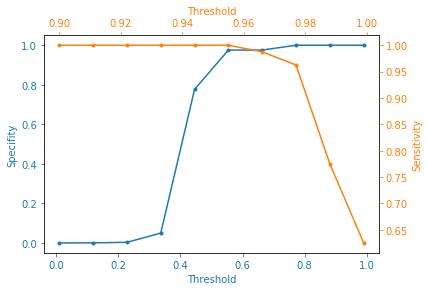

In [58]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(thresholds2,specifity,'C0.-')
ax.set_xlabel("Threshold", color="C0")
ax.set_ylabel("Specifity", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(thresholds1,sensitivity,'C1.-')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Threshold', color="C1") 
ax2.set_ylabel('Sensitivity', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")